# Histogram fits with `pyhf`

Often we don't have a clear way to parametrize our fit templates, so we need to resort to MC simulations and use histograms as templates that we fit to data in the same bins.

We are going to use the [`pyhf`](https://github.com/scikit-hep/pyhf) package for these fits. The documentation can be found at https://pyhf.readthedocs.io/.

It can be installed with pip, e.g.

`pip install --user pyhf`

In addition we are using `iminuit` to extract uncertainties on fit parameters.

`pip install --user iminuit`

This is an adapted version of the notebook presented [here](https://github.com/nikoladze/HEPFittingTutorial/blob/master/examples/jupyter_notebooks/006_histogram_fits_with_pyhf.ipynb). 

In [91]:
# ! pip install pyhf numpy matplotlib iminuit ipywidgets

In [92]:
import pyhf
import matplotlib.pyplot as plt
import numpy as np
import json

Let's create 2 artificial histograms with 10 bins (having 11 bin boundaries). You could imagine these as two different background processes for which we have MC simulations on which we ran some event selection and created histograms for. For now, let's assume that the shape of these distributions comes out correctly and we only need to fit the normalization (for both templates independently) to data.

In [93]:
bins = np.arange(11)
bin_cents = (bins[1:]+bins[:-1])/2

In [94]:
hist1 = np.array([1.5, 3., 6., 7.5, 6.3, 6.6, 6., 4.5, 3. , 1.5])
hist2 = np.array([3. , 6., 9., 12., 15., 9. , 6., 3. , 0.3, 0.15])

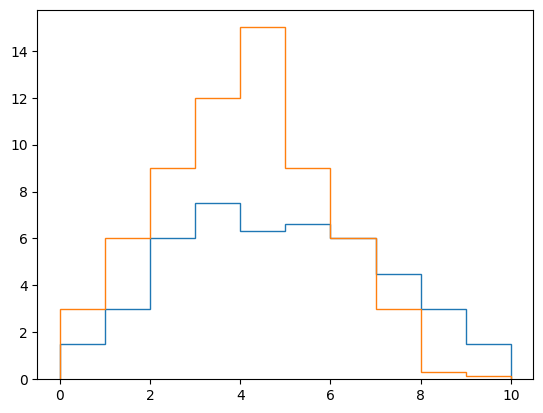

In [95]:
plt.stairs(hist1, bins)
plt.stairs(hist2, bins)

We want to stack them since we think the sum of both should give us the expected data yield

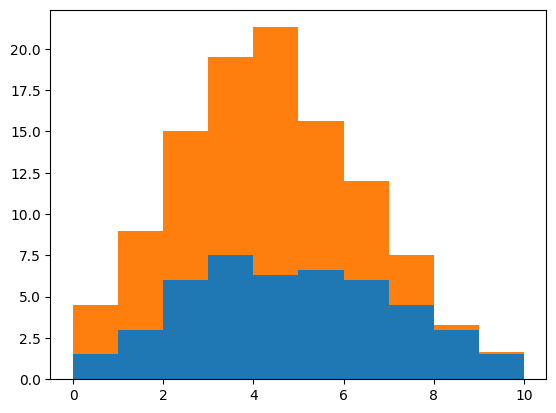

In [96]:
plt.stairs(hist1, bins, fill=True)
plt.stairs(hist1+hist2, bins, fill=True, baseline=hist1)

Now, let's assume we observed the following data counts in each bin:

In [97]:
data = np.array([ 4, 17, 26, 23, 34, 23, 21,  7,  8,  4])

We can add the data to the plot using the `histtype="errorbar"` option. This automatically adds Poisson errors ()

<ErrorbarContainer object of 3 artists>

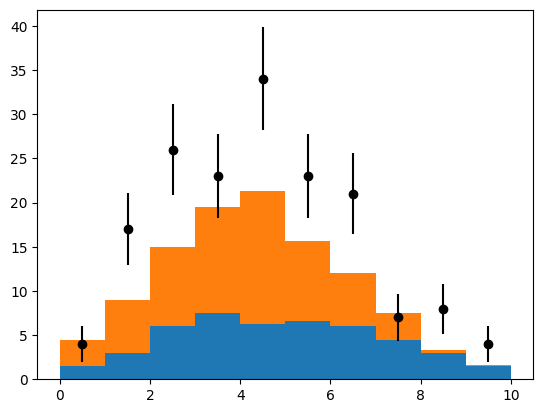

In [98]:
plt.stairs(hist1, bins, fill=True)
plt.stairs(hist1+hist2, bins, fill=True, baseline=hist1)
plt.errorbar(bin_cents, data, fmt='ok', yerr=np.sqrt(data))

## One template fits it all

`pyhf` does fits using the Maximum-Likelihood method and uses the HistFactory ([CERN-OPEN-2012-016](https://cds.cern.ch/record/1456844)) template. In the simplemost case the pdf (probability density function) is just a product of poisson counts in each bin:

$$p(\vec n|\vec\lambda) = \prod_{\mathrm{bin}\, i} \mathrm{Pois}(n_i | \lambda_i)$$

where $\mathrm{Pois}(n_i | \lambda_i)$ is the Poisson distribution for $\lambda_i$ expected and $n_i$ observed counts. In our case $\lambda_i$ would be given by

$$\lambda_i = \mu_1 b_{i, 1} + \mu_2 b_{i, 2}$$

where $b_{i, 1}$ and $b_{i, 2}$ are the expected counts in bin $i$ of our 2 histograms and $\mu_1$ and $\mu_2$ are the normalization factors we want to fit. This pdf will define the Likelihood function that is later maximized to give the best fitting parameter values.

The general template is more complicated, allowing for constraint terms and separation into arbitrary channels - we will come back to that later.

Models in `pyhf` are defined with a json-like specification. That is, a nested structure of lists and dictionaries. The hierarchy is as follows:

* A model can have several **channels**. This can be used to e.g. define different normalization factors for different categories of selection (but they have to be orthogonal)
* Each channel can have several **samples**. Each sample comes with a histogram template.
* Each sample can have several **modifiers**. These will define the fit parameters. Modifiers can be free normalization factors or constraint parameters (more later)

In our case we can define a model with just one channel and two samples which each have a normalization factor (free parameter) as a modifier:

In [99]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu1", "type": "normfactor", "data" : None}
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu2", "type": "normfactor", "data" : None}
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

# info: the `poi_name=None` is nescessary here since we don't want to do a hypothesis test
model = pyhf.Model(spec, poi_name=None)

<div class="alert alert-block alert-warning">
    The histogram bin contents need to be specified as a list (not a numpy array), such that we can really dump this into the text based json format.
</div>

Our specification would look like this as a json string (which can be simply stored in a text file):

In [100]:
print(json.dumps(model.spec, indent=2))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "sample1",
          "data": [
            1.5,
            3.0,
            6.0,
            7.5,
            6.3,
            6.6,
            6.0,
            4.5,
            3.0,
            1.5
          ],
          "modifiers": [
            {
              "name": "mu1",
              "type": "normfactor",
              "data": null
            }
          ]
        },
        {
          "name": "sample2",
          "data": [
            3.0,
            6.0,
            9.0,
            12.0,
            15.0,
            9.0,
            6.0,
            3.0,
            0.3,
            0.15
          ],
          "modifiers": [
            {
              "name": "mu2",
              "type": "normfactor",
              "data": null
            }
          ]
        }
      ]
    }
  ]
}


We will now run a *maximum likelihood fit* that gives us the parameters that maximize the likelihood (technically we will minimize the negative log-likelihood), the *maximum likelihood estimates* (mle).

In [101]:
mu1, mu2 = pyhf.infer.mle.fit(data, model)

In [102]:
mu1, mu2

(1.9224638111350256, 1.241248257446388)

We did not have to specify initial parameter values or bounds. For normalization factors the initial parameters are by default `1` and the bounds (fit range) is `[0, 10]`:

In [103]:
model.config.suggested_init()

[1.0, 1.0]

In [104]:
model.config.suggested_bounds()

[(0, 10), (0, 10)]

Let's look at the fitted templates, together with the data:

<ErrorbarContainer object of 3 artists>

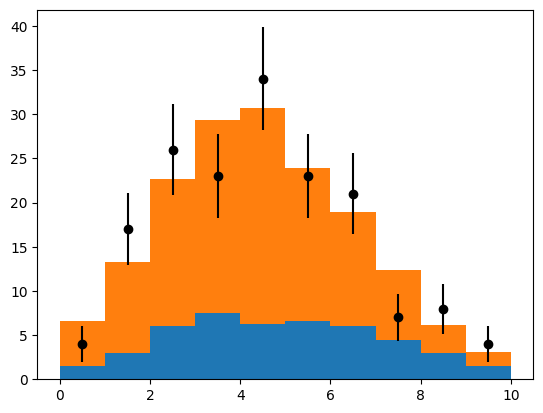

In [105]:
plt.stairs(mu1*hist1, bins, fill=True)
plt.stairs(mu1*hist1+mu2*hist2, bins, fill=True, baseline=hist1)
plt.errorbar(bin_cents, data, fmt='ok', yerr=np.sqrt(data))

## Uncertainties on fit parameters and the "post-fit" plot

Often, we are also interested in the uncertainties and correlations between fit parameters. We can use `iminuit` as a fitting backend for `pyhf` to extract them:

In [106]:
pyhf.set_backend('numpy', 'minuit')

In [107]:
parameters, correlations = pyhf.infer.mle.fit(data, model, return_uncertainties=True, return_correlations=True)

In [108]:
parameters

array([[1.92246381, 0.52692563],
       [1.24124826, 0.37840973]])

In [109]:
correlations

array([[ 1.        , -0.85698692],
       [-0.85698692,  1.        ]])

# Uncertainties on the histogram templates

Our histogram templates are usually derived by MC simulations. We typically want to assign uncertainties on the templates themselves. Those can be of different origin, but mostly fall into the following categories:

* **MC stat. error**: Statistical uncertainty due to the limited simulated sample size. The relative uncertainty on the expected count in a histogram bin is given by $\sqrt{N}/N$ for a bin with $N$ simulated events or $\sqrt{\sum(w_i^2)}/{\sum w_i}$ for weighted events with weights $w_i$ in that bin.
* **Experimental uncertainties**: Uncertainties on detector simulation or reconstruction/calibration. Many of them are evaluated by re-running the full analysis chain with certain parameters varied up and down by one standard deviation of some measured/calibrated parameters.
* **Theory uncertainties**: Uncertainties on cross sections and on the choice of different theoretical models/approximations (e.g. parton shower) or parameters. Cross section uncertainties affect the normalization, while the others are typically evaluated by re-running the simulation with parameters changed or models/algorithms replaced.

In all cases we need to provide additional input to parametrize the Likelihood template. In `pyhf` this is done by specifying `modifiers` for the samples we want to assign uncertainties to. See

https://pyhf.readthedocs.io/en/v0.7.2/likelihood.html#modifiers

for an overview. Each modifier will come with additional parameters in the Likelihood template. We will discuss 2 cases:

* Uncorrelated uncertainties per bin
    * Special case: MC statistical uncertainty
* Correlated uncertainty across all bins


## Uncorrelated uncertainties per bin

Uncorrelated in this sense means the uncertainty affects each bin individually.

Let's assume we want to fit just one histogram  this time (using `hist1` as a template) and we have determined the (absolute) uncertainty per bin as:

In [110]:
hist1_uncorr_err = np.array([0.4 , 0.4 , 0.3 , 0.2 , 0.15, 0.4 , 0.45, 0.5 , 0.3 , 0.35])

In addition to our normalization factor, we add another modifier to the sample of type `shapesys`. This will create a template with an additional uncertainty for each bin. We need to specify the uncertainty per bin for the `"data"` entry of the modifier dictionary:

In [111]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            # first modifier: normalization factor
            {"name": "mu1", "type": "normfactor", "data" : None},
            # second modifier: uncorrelated uncertainties per bin
            {
                "name": "uncorrelated_uncertainties",
                "type": "shapesys",
                "data" : list(hist1_uncorr_err)
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

model_uncorr = pyhf.Model(spec, poi_name=None)

This will introduce one additional fit parameter per bin, so we have 11 parameters in total, 1 for the normalization factor and 10 for the uncorrelated uncertainty per bin.

In [112]:
model_uncorr.config.npars

11

How does this work? Well, as mentioned these uncertainties usually come from the limited amount of MC samples. In some sense, this is an additional measurement with data from our MC simulation! So we build this into our model by adding **auxiliary data** that emulates this. The pdf for building the likelihood function becomes

$$L(\vec n, \vec a|\vec \lambda, \vec \gamma) = \prod_{\mathrm{data\,bin}\, b} \mathrm{Pois}(n_b | \lambda_b) \prod_{\mathrm{aux\,data\, bin}\, b} \mathrm{Pois}(a_b | \gamma_b a_b)$$

where in our example

$$\lambda_b = \mu_b \gamma_b b_b$$

We determine the amount of auxiliary data $a_b$ per bin by asking "which effective number of entries would give us that relative uncertainty". That is given by

$$\frac{\sqrt{a_b}}{a_b} = \frac{\delta_b}{b_b} \rightarrow a_b = \left(\frac{b_b}{\delta_b}\right)^2$$

where $b_b$ is the expected count and $\delta_b$ the absolute uncertainty in the corresponding histogram bin.

So the auxiliary data for each bin is given by:

In [113]:
list((hist1 / hist1_uncorr_err) ** 2)

[14.0625,
 56.25,
 400.0,
 1406.25,
 1764.0,
 272.2499999999999,
 177.77777777777774,
 81.0,
 100.0,
 18.36734693877551]

which is also what `pyhf` calculated for us:

In [114]:
model_uncorr.config.auxdata

[14.062499999999996,
 56.249999999999986,
 400.0,
 1406.2499999999998,
 1764.0,
 272.24999999999994,
 177.77777777777777,
 81.0,
 100.0,
 18.367346938775512]

The auxdata is set to match the expected counts exactly for the intial parameter values $\gamma_i = 1$:

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


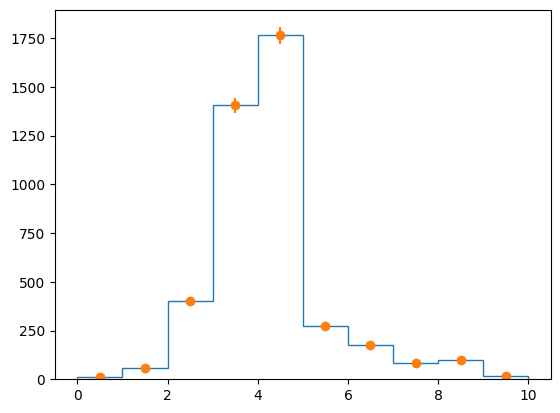

In [115]:
initial_parameters = model_uncorr.config.suggested_init()
plt.stairs(model_uncorr.expected_auxdata(initial_parameters), bins)
plt.errorbar(bin_cents,model_uncorr.config.auxdata, yerr=np.sqrt(model_uncorr.config.auxdata), fmt='o')
print(initial_parameters)

So the parameters $\gamma_b$ need to simultaneously fit the real and auxiliary data. They are therefore not completely free. We say they are "constrained".

Try to manually tune the parameters in the following interactive plot. Observe how the templates that need to fit real and auxiliary data change. Also have a look at the value of the negative log likelihood (which is the objective we want to minimize in the fit). Why can't we get a perfect fit to the actual data?

In [116]:
# You don't need to understand right now what is happening in this code cell, first focus on the application

import ipywidgets as widgets

sliders_gamma = {
    f"gamma{i}" : widgets.FloatSlider(
        1.0,
        min=0.1,
        max=2.0,
        orientation="vertical",
        continuous_update=False,
        description=f"γ{i}",
        layout=widgets.Layout(width='35px')
    )
    for i in range(1, 11)
}

slider_mu = widgets.FloatSlider(
    1.0, min=0.1, max=10.0, description="Norm factor", continuous_update=False
)

def plot(mu, **kwargs):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

    parameters = model_uncorr.config.suggested_init()
    
    parameters[0] = mu
    
    for k in kwargs:
        i = int(k.replace("gamma", ""))
        parameters[i] = kwargs[k]

    axs[0].stairs(model_uncorr.expected_actualdata(parameters), bins)
    axs[0].errorbar(bin_cents, data, yerr=np.sqrt(data), fmt='ok')
    axs[1].stairs(model_uncorr.expected_auxdata(parameters), bins)
    param_set = model_uncorr.config.param_set("uncorrelated_uncertainties")
    axs[1].errorbar(
        bin_cents,
        model_uncorr.config.auxdata,
        yerr=model_uncorr.config.auxdata * np.array(param_set.width()),
        fmt='or'
    )
    axs[0].set_title("Actual data")
    axs[1].set_title("Auxiliary data")
    
    fig.tight_layout()
    
    print(
        "Negative Log-Likelihood: "
        f"{- model_uncorr.logpdf(parameters, np.concatenate([data, model_uncorr.config.auxdata]))[0]:.3f}"
    )
    
interactive_plot = widgets.interactive_output(plot, dict(sliders_gamma, mu=slider_mu))
interactive_plot.layout.height = "400px"

def fit(b):
    parameters = pyhf.infer.mle.fit(np.concatenate([data, model_uncorr.config.auxdata]), model_uncorr)
    slider_mu.value = parameters[0]
    for k in sliders_gamma:
        i = int(k.replace("gamma", ""))
        sliders_gamma[k].value = parameters[i]
        
button = widgets.Button(description="Fit")
button.on_click(fit)

display(
    slider_mu,
    widgets.HBox(
        [widgets.HBox(layout=widgets.Layout(width='45px'))]
        + [sliders_gamma[f"gamma{i}"] for i in range(1, 11)]
    ),
    button,
    interactive_plot
)

FloatSlider(value=1.0, continuous_update=False, description='Norm factor', max=10.0, min=0.1)

Button(description='Fit', style=ButtonStyle())

Output(layout=Layout(height='400px'))

### Special case: Statistical uncertainties

As the sample counts are often derived from Monte Carlo (MC) datasets, they necessarily carry an uncertainty due to the finite sample size of the datasets. Adding uncertainties for each sample would yield a very large number of nuisance parameters with limited utility. Therefore a set of bin-wise scale factors $\gamma_{b}$ is introduced to model the overall uncertainty in the bin due to MC statistics.

This effectively means that we can add statsitical errors as `staterror` modifier, and they will be quadratically combined across samples for each bin, given that they carry the same modifier name. Channels are still kept seperate.

The constraint term for the `staterror` modifier is a product of Gaussians over bins ([which might change in the future](https://github.com/scikit-hep/pyhf/issues/760)). The pdf for building the likelihood function becomes

$$L(\vec n, \vec a|\vec \lambda, \vec \gamma) = \prod_{\mathrm{data\,bin}\, b} \mathrm{Pois}(n_b | \lambda_b ) \prod_{\mathrm{aux\,data\, bin}\, b} \text{Gauss}(a_b=1 | \gamma_b, \sigma_b)$$

where in our example

$$\lambda_b = \gamma_b \mu_{1b} b_{1b} + \gamma_b \mu_{2b} b_{2b},$$

since we have two samples now (`sample1` and `sample2`). The $\gamma_b$ are factors of around 1 and shared between samples

$$\sigma_b = \sqrt{\sum_{\mathrm{samples}\, s} \delta_{sb}^2} \Bigg/ \sum_{\mathrm{samples}\, s} b_{sb},$$

where $b_{sb}$ are the bin counts and $\delta_{sb}$ are the absolute uncertainties in each bin, for each sample.

In [117]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1),
        "modifiers": [
            {"name": "mu1", "type": "normfactor", "data" : None},
            {
                "name": "statistical_error",                        # same name
                "type": "staterror",
                "data" : list(np.sqrt(hist1))                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "statistical_error",                        # same name
                "type": "staterror",
                "data" : list(np.sqrt(hist2))                       # absolute yield uncertainties in each bin (Poisson error)
            }
        ],
    },
]

spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

model_uncorr = pyhf.Model(spec, poi_name=None)

We expect 2 modifiers for the normalisations and 10 modifiers due to the statistical uncertainty.

In [118]:
model_uncorr.config.npars

12

Let us see what the model calculated for the $\sigma_b$:

In [119]:
model_uncorr.config.param_set("statistical_error").width()

[0.4714045207910316,
 0.3333333333333333,
 0.2581988897471611,
 0.22645540682891915,
 0.21667569500871975,
 0.25318484177091666,
 0.28867513459481287,
 0.3651483716701107,
 0.5504818825631803,
 0.778498944161523]

We can verify this by hand using 

In [120]:
list(np.sqrt(hist1 + hist2)/(hist1+hist2))

[0.4714045207910316,
 0.3333333333333333,
 0.25819888974716115,
 0.22645540682891918,
 0.21667569500871972,
 0.25318484177091666,
 0.28867513459481287,
 0.36514837167011077,
 0.5504818825631803,
 0.778498944161523]

Try to manually tune the parameters in the following interactive plot. Observe how the templates that need to fit real and auxiliary data change. Also have a look at the value of the negative log likelihood (which is the objective we want to minimize in the fit). Why can't we get a perfect fit to the actual data?

In [159]:
# You don't need to understand right now what is happening in this code cell, first focus on the application

import ipywidgets as widgets

sliders_gamma = {
    f"gamma{i}" : widgets.FloatSlider(
        1.0,
        min=0.1,
        max=2.0,
        orientation="vertical",
        continuous_update=False,
        description=f"γ{i}",
        layout=widgets.Layout(width='35px')
    )
    for i in range(1, 11)
}

slider_mu1 = widgets.FloatSlider(
    1.0, min=0.1, max=10.0, description="Norm fact. 1", continuous_update=False
)

slider_mu2 = widgets.FloatSlider(
    1.0, min=0.1, max=10.0, description="Norm fact. 2", continuous_update=False
)

par_slice = model_uncorr.config.par_slice

def plot(mu1, mu2, **kwargs):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

    parameters = model_uncorr.config.suggested_init()
    
    parameters[par_slice("mu1").start] = mu1
    parameters[par_slice("mu2").start] = mu2
    
    for k in kwargs:
        i = int(k.replace("gamma", ""))+1
        parameters[i] = kwargs[k]
    
    expected_data = model_uncorr.main_model.expected_data(parameters, return_by_sample=True)
    axs[0].stairs(expected_data[0], bins, fill=True, label='sample1')
    axs[0].stairs(expected_data[0] + expected_data[1], bins, fill=True, baseline=expected_data[0], label='sample2')
    axs[0].errorbar(bin_cents, data, yerr=np.sqrt(data), fmt='ok')
    axs[1].stairs(model_uncorr.expected_auxdata(parameters), bins)
    param_set = model_uncorr.config.param_set("statistical_error")
    axs[1].errorbar(
        bin_cents,
        model_uncorr.config.auxdata,
        yerr=model_uncorr.config.auxdata * np.array(param_set.width()),
        fmt='or'
    )
    axs[0].set_title("Actual data")
    axs[0].legend()
    axs[1].set_title("Auxiliary data")
    
    fig.tight_layout()
    
    print(
        "Negative Log-Likelihood: "
        f"{- model_uncorr.logpdf(parameters, np.concatenate([data, model_uncorr.config.auxdata]))[0]:.3f}"
    )
    
interactive_plot = widgets.interactive_output(plot, dict(sliders_gamma, mu1=slider_mu1, mu2=slider_mu2))
interactive_plot.layout.height = "400px"

def fit(b):
    parameters = pyhf.infer.mle.fit(np.concatenate([data, model_uncorr.config.auxdata]), model_uncorr)
    slider_mu1.value = parameters[par_slice("mu1").start]
    slider_mu2.value = parameters[par_slice("mu2").start]
    
    for k in sliders_gamma:
        i = int(k.replace("gamma", ""))+1
        sliders_gamma[k].value = parameters[i]
        
button = widgets.Button(description="Fit")
button.on_click(fit)

display(
    slider_mu1,
    slider_mu2,
    widgets.HBox(
        [widgets.HBox(layout=widgets.Layout(width='45px'))]
        + [sliders_gamma[f"gamma{i}"] for i in range(1, 11)]
    ),
    button,
    interactive_plot
)

FloatSlider(value=1.0, continuous_update=False, description='Norm fact. 1', max=10.0, min=0.1)

FloatSlider(value=1.0, continuous_update=False, description='Norm fact. 2', max=10.0, min=0.1)

Button(description='Fit', style=ButtonStyle())

Output(layout=Layout(height='400px'))

## Correlated uncertainty on template shape

Another important type of uncertainty is a parameter correlated across all bins that changes the shape of the template as a whole.

Typically this is used for systematic uncertainties where we recreate the histogram for MC created with some experimental parameter varied up and down by 1 standard deviation (typically done centrally by the experiment's performance groups).

In [125]:
samples = [
    {
        "name": "sample1",
        "data": list(hist1 + 0.5 * hist2),
        "modifiers": [
            # first modifier: normalization factor
            {"name": "mu1", "type": "normfactor", "data" : None},
            # second modifier: correlated uncertainty on template shape
            {
                "name": "alpha",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist1),
                    "hi_data": list(hist1 + hist2)
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

model_corr =  pyhf.Model(spec, poi_name=None)

This time we only have 1 extra parameter

In [126]:
model_corr.config.par_names

['alpha', 'mu1']

This time the constraint term is a standard normal distribution and the auxilary data is set to 0. To get the correct impact on our histogram templates, each bin is interpolated such that it ends up at the "low" value when the nuiscance parameter $\alpha=-1$, at the expected value for $\alpha=0$ and at the "high" value for $\alpha=1$. It is also extrapolated for values of $\alpha$ outside that range.

We won't discuss the details of the interpolation functions here, but if you are interested, here they are:

https://pyhf.readthedocs.io/en/v0.7.2/api.html#interpolators

The default for `histosys` currently is "piecewise-linear interpolation strategy, with polynomial at $|a|<1$", `code4p`

In [127]:
import mplhep as hep

In [128]:
slider_alpha = widgets.FloatSlider(
    0, min=-2, max=2, description="Alpha", continuous_update=False
)

slider_mu = widgets.FloatSlider(
    1.0, min=0.1, max=10.0, description="Norm factor", continuous_update=False
)

par_slice = model_corr.config.par_slice

def plot(mu, alpha):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

    parameters = model_corr.config.suggested_init()
    
    parameters[par_slice("mu1").start] = mu
    parameters[par_slice("alpha").start] = alpha

    axs[0].stairs(model_corr.expected_actualdata(parameters), bins)
    axs[0].errorbar(bin_cents, data, yerr=np.sqrt(data), fmt='ok')
    axs[0].stairs(hist1, bins, fill=True, alpha=0.2, label='hist1')
    axs[0].stairs(hist1+hist2, bins, fill=True, alpha=0.2, baseline=hist1, label='hist2')
    axs[0].legend()
    
    hep.histplot(model_corr.expected_auxdata(parameters), [0, 1], ax=axs[1])
    param_set = model_corr.config.param_set("alpha")
    hep.histplot(
        model_corr.config.auxdata,
        [0, 1],
        yerr=np.array(param_set.width()),
        histtype="errorbar", color="red",
        ax=axs[1]
    )
    axs[0].set_title("Actual data")
    axs[1].set_title("Auxiliary data")
    
    print(
        "Negative Log-Likelihood: "
        f"{- model_corr.logpdf(parameters, np.concatenate([data, model_corr.config.auxdata]))[0]:.3f}"
    )
    
interactive_plot = widgets.interactive_output(plot, dict(mu=slider_mu, alpha=slider_alpha))
interactive_plot.layout.height = "400px"

def fit(b):
    parameters = pyhf.infer.mle.fit(np.concatenate([data, model_corr.config.auxdata]), model_corr)
    slider_mu.value = parameters[par_slice("mu1").start]
    slider_alpha.value = parameters[par_slice("alpha").start]
        
button = widgets.Button(description="Fit")
button.on_click(fit)

display(
    slider_mu,
    slider_alpha,
    button,
    interactive_plot
)

FloatSlider(value=1.0, continuous_update=False, description='Norm factor', max=10.0, min=0.1)

FloatSlider(value=0.0, continuous_update=False, description='Alpha', max=2.0, min=-2.0)

Button(description='Fit', style=ButtonStyle())

Output(layout=Layout(height='400px'))